# Photonic Band Gap, lab report

In [15]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from pprint import pprint
import scipy
from utils import *

%matplotlib inline

# minimal plot style
plt.rcParams['figure.figsize'] = [10, 5]

# globals
prj_path = os.getcwd()
rel_path = 'labeldata'
full_path = os.path.join(prj_path, rel_path)
files = [f for f in os.listdir(full_path) if os.path.isfile(os.path.join(full_path, f))]
print(f'importing these files:')
pprint(files, compact=True)

df = pd.concat([pd.read_csv(os.path.join(rel_path, file)) for file in files])
print(f"list of measured samples: {df['sample'].unique()}")

df

importing these files:
['30-05-24_R0.txt', '30-05-24_R1.txt', '30-05-24_R2.txt', '30-05-24_R3.txt',
 '30-05-24_R4.txt', '30-05-24_R5.txt', '30-05-24_R6.txt', '20-06-24_R0.txt',
 '20-06-24_R1.txt', '20-06-24_R2.txt', '20-06-24_R3.txt', '20-06-24_R4.txt',
 '20-06-24_R5.txt', '20-06-24_R6.txt', '20-06-24_R7.txt', '20-06-24_R8.txt',
 '20-06-24_R9.txt', '20-06-24_R10.txt', '20-06-24_R11.txt', '20-06-24_R12.txt',
 '20-06-24_R13.txt', '20-06-24_R14.txt', '20-06-24_R15.txt', '20-06-24_R16.txt',
 '20-06-24_R17.txt', '20-06-24_R18.txt']
list of measured samples: ['AIR' 'SIL' 'PCR' 'CAL' 'BOX']


,id,frequency_GHz,peak_mV,sigma_peak_mV,noise_mV,sigma_noise_mV,sample,antenna
0,30-05-24_R0,0.250000,6.890000,NaN,0.210000,NaN,AIR,LF
1,30-05-24_R0,0.333333,6.820000,NaN,0.192000,NaN,AIR,LF
2,30-05-24_R0,0.416667,7.130000,NaN,0.226000,NaN,AIR,LF
3,30-05-24_R0,0.500000,6.620000,NaN,0.225000,NaN,AIR,LF
4,30-05-24_R0,0.583333,6.810000,NaN,0.203000,NaN,AIR,LF
...,...,...,...,...,...,...,...,...
95,20-06-24_R18,5.767680,0.938457,0.101884,0.557000,0.006000,PCR,HF
96,20-06-24_R18,5.825760,0.831246,0.108337,0.547500,0.006921,PCR,HF
97,20-06-24_R18,5.883840,1.030560,0.097922,0.590667,0.004885,PCR,HF
98,20-06-24_R18,5.941920,0.953959,0.066346,0.572667,0.008383,PCR,HF


## Analisi della distorsione del segnale

Come prima cosa è opportuno valutare la presenza di artefatti dell'apparato di misura che andranno sottratti dal segnale. 
Sia il generatore che l'analizzatore danno delle risposte diverse a diverse frequenze, ad esempio il generatore produce un segnale più intenso a basse frequenze, e così via. Ci sono anche gli effetti prodotti dalla scatola con la schermatura, essa produce delle onde stazionarie e delle risonanze che si sommano all'effetto del cristallo fotonico.
In particolare l'analisi del rumore deve tenere conto di:

- distorsioni del generatore e del ricevitore in presa diretta (CAL)
- effetti dovuti alla configurazione reciproca in aria dell'antenna e ricevitore (AIR)
- onde stazionarie dovute alla presenza dell'apparato di schermamento (BOX)

Cominciamo quindi dall'analisi di queste due per capire i loro effetti

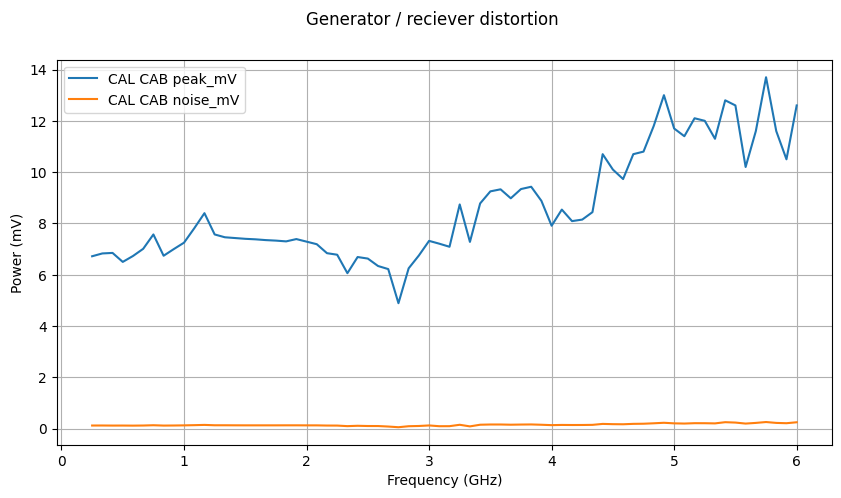

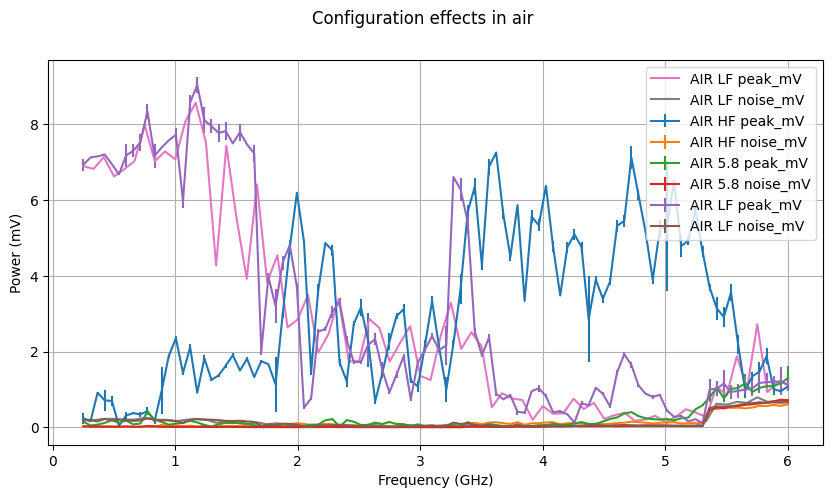

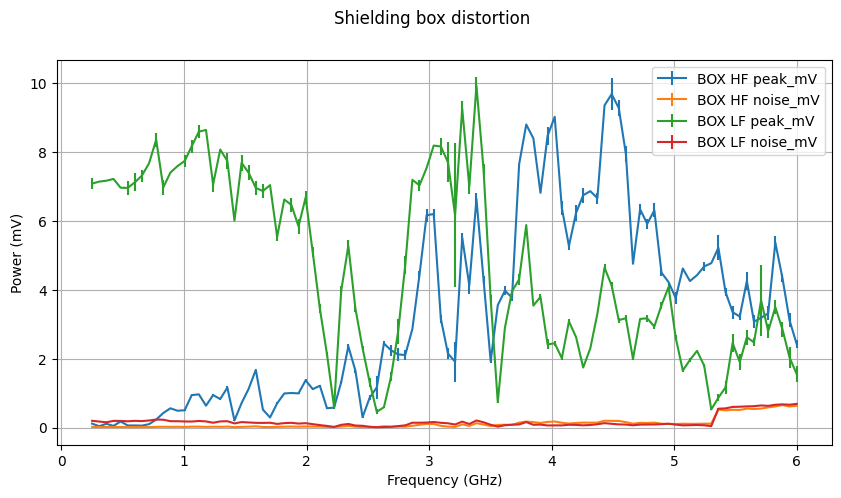

In [16]:
plotByID(df[df['sample'] == 'CAL'], 'Generator / reciever distortion')
plotByID(df[df['sample'] == 'AIR'], 'Configuration effects in air')
plotByID(df[df['sample'] == 'BOX'], 'Shielding box distortion')

Dal grafico "Generator \ Reciever distortion" emerge che il segnale non ha lo stesso gain su tutta la banda, andrà quindi rinormalizzato per eliminare l'amplificazione del segnale da parte dei trasmettitori in questo modo:

$$
 normalized\_signal = \frac{signal}{cal\_signal - cal\_noise}
$$

Per eliminare effetti dovuti alle fluttuazioni del segnale sarebbe da interpolare il gain con una funzione continua. Per motivi di semplicità si è scelto di usare un polinomio di secondo grado come approssimante. 

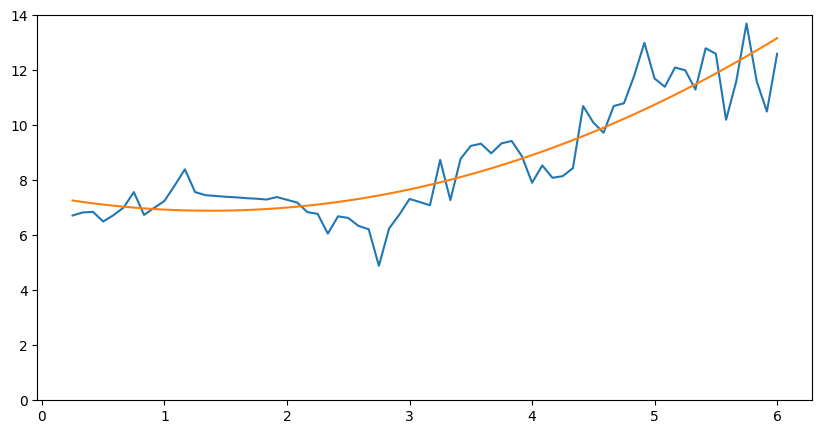

In [17]:
def getGain():
    '''
        Get the gain for each frequency by interpolating
        the measures as a polynomial
    '''
    subset = df[df['sample'] == 'CAL']
    x = subset['frequency_GHz'].values.tolist()
    y = subset['peak_mV'].values.tolist()
    coeff = np.polyfit(x,y,2)

    ax = plt.subplot()
    ax.plot(x,y)
    ax.plot(x, np.polyval(coeff, x))

    ax.set_ylim(0,14)
    return coeff

gain_coeff = getGain()

/tmp/ipykernel_42436/2645322125.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


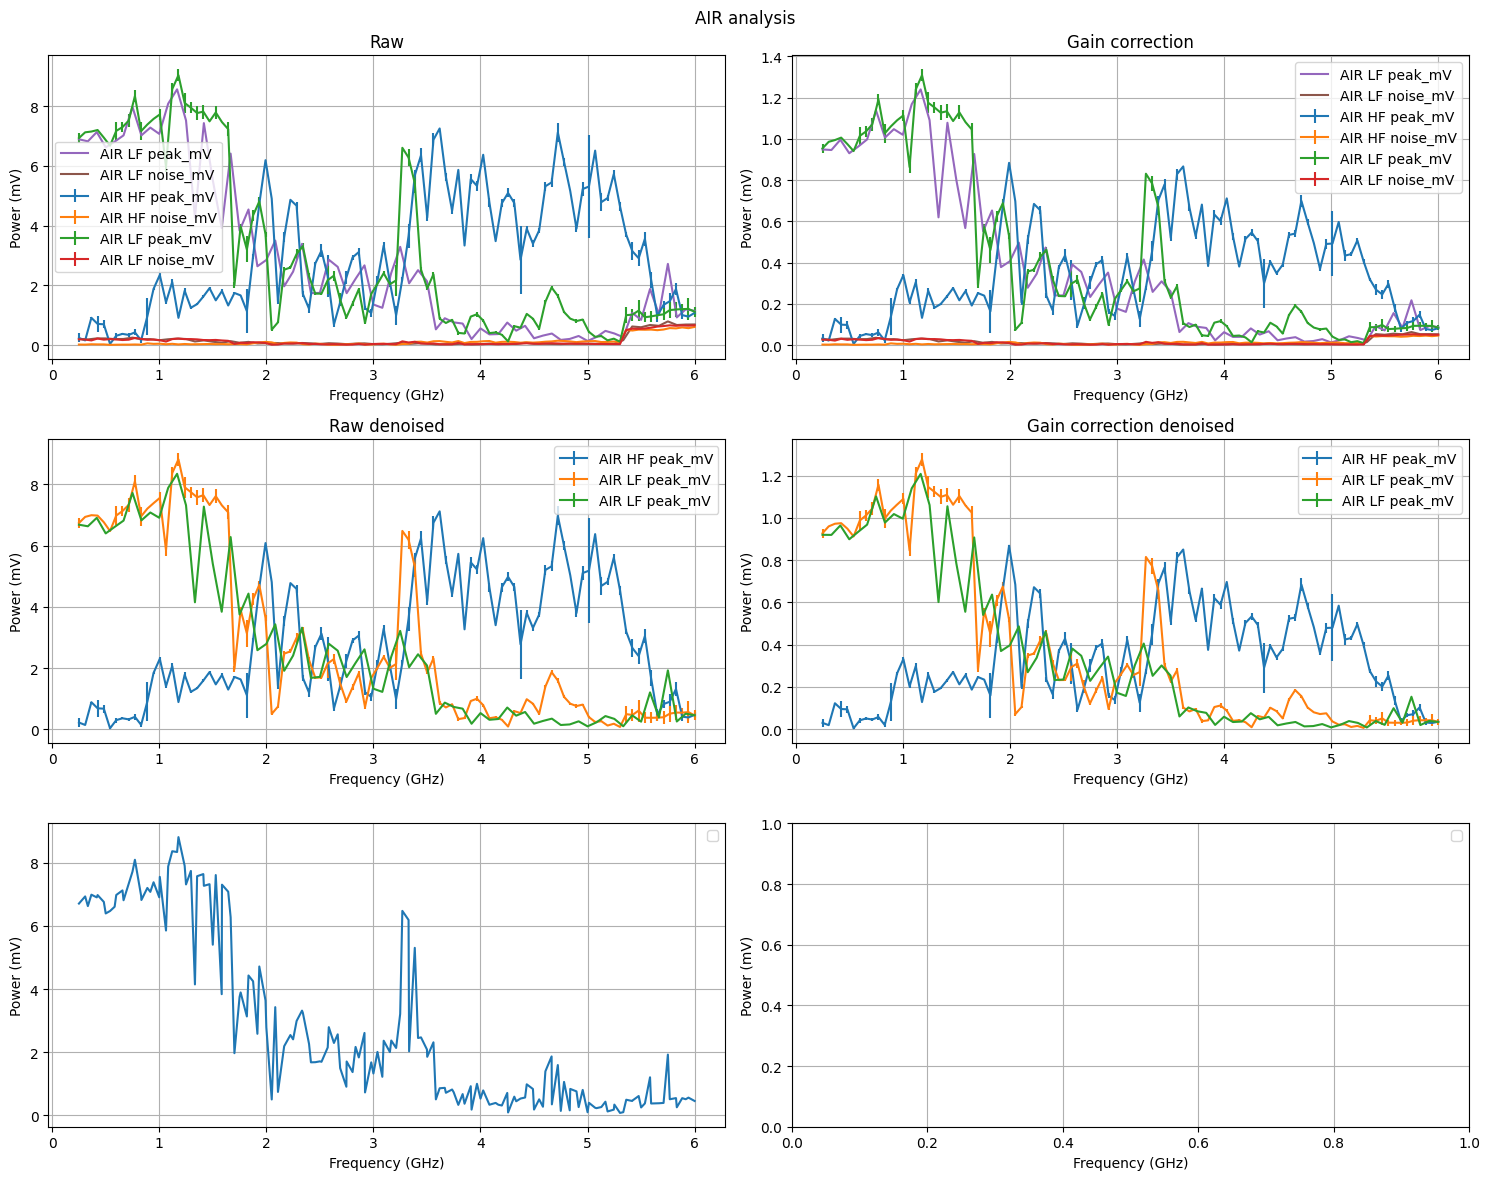

In [22]:
def correctGain(subset : pd.DataFrame, coeff : np.ndarray):
    outset = subset.copy()
    for f in ['peak_mV', 'sigma_peak_mV', 'noise_mV', 'sigma_noise_mV']:
        if f not in outset.columns:
            continue
        outset.loc[:, f] = subset.loc[:, f] / np.polyval(coeff, subset.loc[:, 'frequency_GHz'])
    return outset

def denoise(x : pd.Series):
    '''
        Removes the noise from the peak for each row of the dataset.
        DROPS NOISE AND SIGNOISE COLUMNS
    '''
    x['peak_mV'] = x['peak_mV'] - x['noise_mV']
    x['sigma_peak_mV'] = np.sqrt(np.sum(np.square(x[['sigma_peak_mV', 'sigma_noise_mV']])))
    x = x.drop(['noise_mV','sigma_noise_mV'])
    return x

def testStuff():
    '''
        Try some stuff with AIR signals
    '''

   
    subset =  df.query(' sample == "AIR" and antenna != 5.8 ')

    fig, axs = plt.subplots(3,2, figsize = (15,12))

    # RAW
    subset.groupby(subset['id']).apply(plotThis, axs[0,0], include_groups=False)
    axs[0,0].set_title('Raw')

    # GAIN CORRECTION
    correctGain(subset, gain_coeff).groupby('id').apply(plotThis, axs[0,1], include_groups=False)
    axs[0,1].set_title('Gain correction')

    # RAW DENOISED
    denoised = subset.apply(denoise, axis=1)
    denoised.groupby('id').apply(plotThis, axs[1,0], include_groups=False)
    axs[1,0].set_title('Raw denoised')

    # GAIN CORRECTION DENOISED
    correctGain(denoised, gain_coeff).groupby('id').apply(plotThis, axs[1,1], include_groups=False)
    axs[1,1].set_title('Gain correction denoised')

    # MEAN RAW DENOISED
    m = denoised[denoised['antenna'] == 'LF']
    m = m[[k.freq, k.pek]].groupby(k.freq).apply(np.mean, include_groups = False)

    axs[2,0].plot(m.index.values, m.values)

    for ax in axs.flatten():
        ax.grid(True)
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel('Power (mV)')
        ax.legend()

    fig.suptitle('AIR analysis')
    fig.tight_layout()

testStuff()